## Forecasting Oil Prices with TSFresh

In this notebook, we would like to be able to forecast the stock price returns of oil prices using the features generated by TSFresh. We attempt to compare the difference between the performance of utilizing TSFresh extracted features versus macroeconomic indicators and Google trends data and see whether TSFresh features could serve as a substitute of the other.

In [65]:
import os
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Bidirectional
from keras.models import Sequential
from statsmodels.graphics.tsaplots import plot_acf

In [66]:
import matplotlib
import keras
import tsfresh

print('Tensorflow Version: ', tf.__version__)
print('Matplotlib Version: ', matplotlib.__version__)
print('Numpy Version: ', np.__version__)
print('Pandas Version: ', pd.__version__)
print('Keras Version: ', keras.__version__)
print('tsFresh Version: ', tsfresh.__version__)

Tensorflow Version:  2.9.1
Matplotlib Version:  3.4.3
Numpy Version:  1.22.4
Pandas Version:  1.4.0
Keras Version:  2.9.0
tsFresh Version:  0.19.0


\begin{align*}
    PercentChange = \frac{Price_t - Price_{t-1}}{Price_{t-1}} * 100
\end{align*}

In [67]:
df_crude = pd.read_csv('data/dubai_crude_oil.csv')
df_crude['Date'] = pd.to_datetime(df_crude['Date'], dayfirst=True)
df_crude = df_crude[df_crude['Date'] >= datetime.datetime(2014, 7, 11)]
df_crude = df_crude.sort_values(by='Date').reset_index().drop('index', axis=1)
df_crude = df_crude[['Date', 'Price']].set_index('Date')
df_crude['Lag'] = df_crude['Price'].shift(1)

df_crude = df_crude.dropna()
df_crude['Return'] = ((df_crude['Price'] - df_crude['Lag']) / df_crude['Lag']) * 100
df_crude

,Price,Lag,Return
Date,,,
2014-07-14,106.19,105.79,0.378108
2014-07-15,105.89,106.19,-0.282512
2014-07-16,105.94,105.89,0.047219
2014-07-17,106.36,105.94,0.396451
2014-07-18,105.97,106.36,-0.366679
...,...,...,...
2022-05-27,107.75,107.64,0.102192
2022-05-31,108.13,107.75,0.352668
2022-06-01,110.91,108.13,2.570979


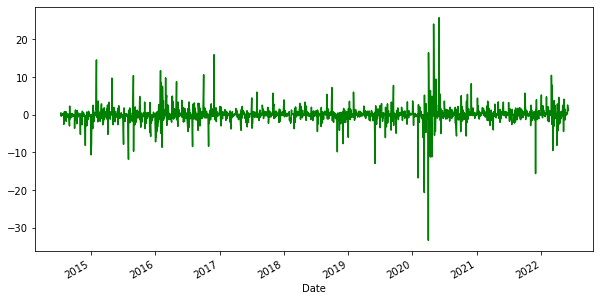

In [68]:
df_crude['Return'].plot(figsize=(10, 5), color='green')
plt.autoscale()
plt.show()

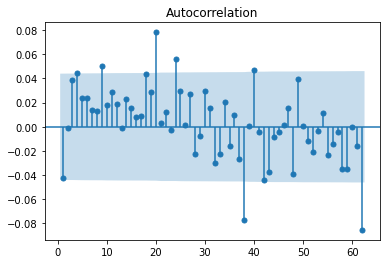

In [69]:
plot_acf(df_crude['Return'], lags=62, zero=False)
plt.autoscale()
plt.show()

## Forecasting Returns

In [70]:
df_commodity = pd.read_csv('data/crb_commodity_index.csv')
df_commodity['Date'] = pd.to_datetime(df_commodity['Date'], dayfirst=True)
df_commodity = df_commodity[df_commodity['Date'] >= datetime.datetime(2014, 7, 14)]
df_commodity = df_commodity.drop(['Open', 'High', 'Low'], axis=1)
df_commodity = df_commodity.rename(columns={'Close': 'crb_index'})
df_commodity = df_commodity.set_index('Date')
df_commodity

,crb_index
Date,
2014-07-14,297.4700
2014-07-15,296.0200
2014-07-16,296.7900
2014-07-17,297.9200
2014-07-18,297.4200
...,...
2022-05-27,320.5242
2022-05-31,316.5352
2022-06-01,320.0229


In [71]:
df_dollar = pd.read_csv('data/us_dollar_index.csv')
df_dollar = df_dollar.dropna()
df_dollar['Date'] = pd.to_datetime(df_dollar['Date'], dayfirst=True)
df_dollar = df_dollar[df_dollar['Date'] >= datetime.datetime(2014, 7, 14)]
df_dollar = df_dollar.sort_values(by='Date')
df_dollar = df_dollar[['Date', 'Price']]
df_dollar = df_dollar.rename(columns={'Price': 'us_dollar_index'})
df_dollar = df_dollar.set_index('Date')

df_dollar

,us_dollar_index
Date,
2014-07-14,80.230
2014-07-15,80.446
2014-07-16,80.625
2014-07-17,80.570
2014-07-18,80.595
...,...
2022-05-30,101.305
2022-05-31,101.766
2022-06-01,102.529


In [72]:
gtrends_df = pd.read_csv('data/crude-oil-daily-2014-2022.csv')
gtrends_df = gtrends_df.rename(columns={'Day': 'Date', 'crude oil: (Worldwide)': 'google_searches'})
gtrends_df = gtrends_df.drop(['Unnamed: 0'], axis=1)
gtrends_df['Date'] = pd.to_datetime(gtrends_df['Date'])
gtrends_df = gtrends_df.set_index('Date')
gtrends_df

,google_searches
Date,
2014-04-28,18
2014-04-29,15
2014-04-30,15
2014-05-01,19
2014-05-02,14
...,...
2022-05-29,9
2022-05-30,17
2022-05-31,22


In [73]:
ts_df = pd.merge(df_crude['Return'], df_commodity, left_index=True, 
                 right_index=True, how='left')
ts_df = pd.merge(ts_df, df_dollar, left_index=True,
                 right_index=True, how='left')
ts_df = pd.merge(ts_df, gtrends_df, left_index=True,
                 right_index=True, how='left').dropna()
ts_df

,Return,crb_index,us_dollar_index,google_searches
Date,,,,
2014-07-14,0.378108,297.4700,80.230,13.0
2014-07-15,-0.282512,296.0200,80.446,16.0
2014-07-16,0.047219,296.7900,80.625,15.0
2014-07-17,0.396451,297.9200,80.570,15.0
2014-07-18,-0.366679,297.4200,80.595,11.0
...,...,...,...,...
2022-05-26,0.438556,318.6633,101.858,16.0
2022-05-27,0.102192,320.5242,101.698,17.0
2022-05-31,0.352668,316.5352,101.766,22.0


In [74]:
ts_df.isna().sum()

Return             0
crb_index          0
us_dollar_index    0
google_searches    0
dtype: int64

## Train-Test-Split & Normalization

In [11]:
# 70-20-10 split
train_size = int(0.7 * len(ts_df))
val_size = int(0.2 * len(ts_df))
test_size = len(ts_df) - train_size - val_size

print(f'Train size: {train_size}')
print(f'  Val size: {val_size}')
print(f' Test size: {test_size}')

Train size: 1389
  Val size: 397
 Test size: 199


In [12]:
# Normalize per dataframe column
train_mean = ts_df[:train_size].mean()
train_std = ts_df[:train_size].std()

ts_df_norm = (ts_df - train_mean) / train_std

ts_df_norm

,Return,crb_index,us_dollar_index,google_searches
Date,,,,
2014-07-14,0.214660,3.569538,-3.635550,-1.899996
2014-07-15,-0.143519,3.518296,-3.582877,-1.751940
2014-07-16,0.035257,3.545507,-3.539228,-1.801292
2014-07-17,0.224606,3.585440,-3.552640,-1.801292
2014-07-18,-0.189153,3.567771,-3.546543,-1.998700
...,...,...,...,...
2022-05-26,0.247434,4.318486,1.638519,-1.751940
2022-05-27,0.065063,4.384249,1.599503,-1.702588
2022-05-31,0.200867,4.243282,1.616085,-1.455828


In [13]:
target = ['Return']
covariates = ['crb_index', 'us_dollar_index', 'google_searches']

ts = ts_df_norm[target + covariates].to_numpy() # we assume first column is the target
ts_train = ts[:train_size]
ts_val = ts[train_size:train_size+val_size]
ts_test = ts[train_size+val_size:]

In [14]:
# Hyperparms
w = 20 # one month lookback 
h = 5 # predict next 24 hours 

# Other params
batch_size = 1
seed = 42
shuffle = False

# Create train iterators
x_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create val iterators
x_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create test iterators
x_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# zip datasets
train_ds = tf.data.Dataset.zip((x_train, y_train))
val_ds = tf.data.Dataset.zip((x_val, y_val))
test_ds = tf.data.Dataset.zip((x_test, y_test))

# check sizes
for inputs, targets in train_ds:
    print(inputs.shape)
    print(targets.shape)
    break

2022-06-07 10:27:38.238900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 10:27:39.025894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3e:00.0, compute capability: 6.1


(1, 20, 4)
(1, 5)


In [15]:
for inputs, targets in test_ds:
    print(inputs)
    print(targets)
    print('---')

tf.Tensor(
[[[-0.71378356  0.44523164 -0.37815119  0.17278502]
  [-0.33304627  0.37095623 -0.39765949  0.27148887]
  [ 0.94003416  0.5461102  -0.52860896  0.27148887]
  [ 0.44334139  0.65827956 -0.54567873  0.1234331 ]
  [ 0.1191723   0.71552866 -0.56250464 -0.02462267]
  [-0.15428843  0.70356642 -0.50251661  0.17278502]
  [ 0.16626622  0.80272398 -0.59615646 -0.56749381]
  [ 0.0252715   0.81488764 -0.60639831  0.02472926]
  [ 0.03307274  0.76701397 -0.61054383 -0.41943804]
  [ 0.34515712  0.76042679 -0.65590063  0.02472926]
  [ 1.01772477  0.83233095 -0.70979231  0.1234331 ]
  [-0.43188892  0.83584718 -0.7573438  -0.27138228]
  [-0.70415126  0.75810502 -0.64005013 -0.02462267]
  [ 0.53076403  0.80700706 -0.60688602 -0.22203035]
  [-0.56812169  0.77790543 -0.64834116 -0.07397459]
  [ 0.84282973  0.84694361 -0.62151725 -0.61684573]
  [ 0.3240775   0.87420407 -0.60639831 -0.07397459]
  [ 0.07065244  0.88568216 -0.61566476 -0.41943804]
  [ 0.69509948  1.02463138 -0.63517306 -0.12332651]
 

In [16]:
print('Number of train splits: ', len(train_ds))
print('Number of val splits: ', len(val_ds))
print('Number of test splits: ', len(test_ds))

Number of train splits:  1365
Number of val splits:  373
Number of test splits:  175


## Multilayer Perceptron

In [17]:
# MLP

model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 4)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(h, activation="linear")
])

model_mlp.compile(
    optimizer='adam',
    loss='huber',
    metrics=['mae']
)

In [18]:
history_mlp = model_mlp.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
1365/1365 [==============================] - 10s 6ms/step - loss: 0.3542 - mae: 0.6597 - val_loss: 0.7942 - val_mae: 1.1718
Epoch 2/5
1365/1365 [==============================] - 8s 6ms/step - loss: 0.3051 - mae: 0.5846 - val_loss: 0.8317 - val_mae: 1.2274
Epoch 3/5
1365/1365 [==============================] - 9s 6ms/step - loss: 0.2940 - mae: 0.5665 - val_loss: 0.7706 - val_mae: 1.1544
Epoch 4/5
1365/1365 [==============================] - 9s 6ms/step - loss: 0.2860 - mae: 0.5525 - val_loss: 0.7665 - val_mae: 1.1500
Epoch 5/5
1365/1365 [==============================] - 9s 6ms/step - loss: 0.2818 - mae: 0.5459 - val_loss: 0.7854 - val_mae: 1.1708


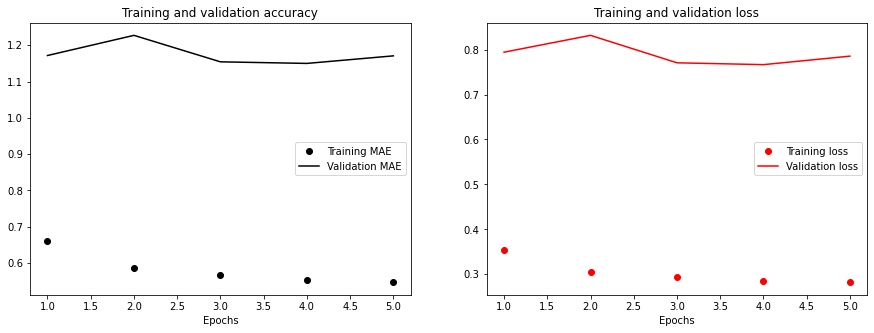

In [20]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    
    # plot accuracy 
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    ax1.plot(epochs, acc, 'ko', label='Training MAE')
    ax1.plot(epochs, val_acc, 'k', label='Validation MAE')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

plot_results(history_mlp)

In [21]:
# unscaled MAE

test_loss, test_mae = model_mlp.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

175/175 [==============================] - 1s 4ms/step - loss: 0.4770 - mae: 0.7985
Test Loss: 0.4770
 Test MAE: 0.7985


RMSE:  0.6305368
 MAE:  0.595302


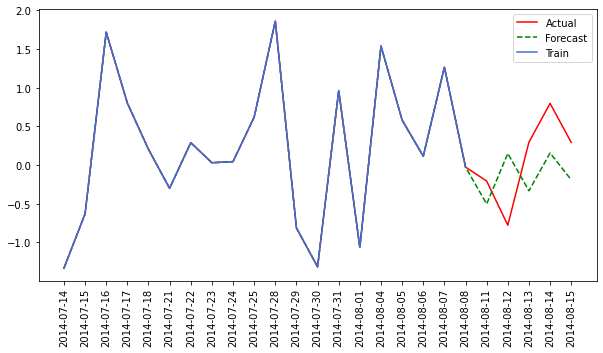

RMSE:  1.4050571
 MAE:  1.0298569


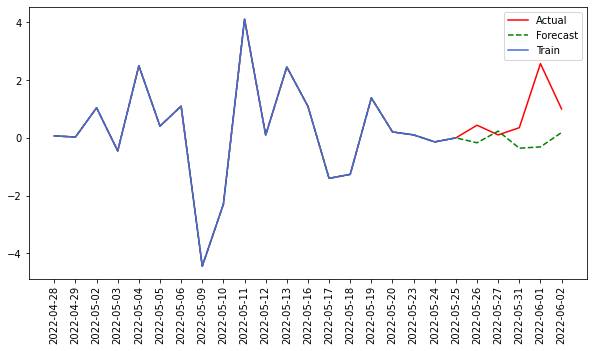

In [22]:
# Sample plots
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_mlp.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
        
        if i == 1 or i == 175:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 175:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [23]:
errs_mlp = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_mlp.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_mlp['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_mlp['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change: ')
print("Avg. RMSE: ", np.mean(errs_mlp['RMSE']))
print(" Avg. MAE: ", np.mean(errs_mlp['MAE']))

In percent change: 
Avg. RMSE:  1.8928516
 Avg. MAE:  1.4728135


## Simple Recurrent Neural Network

In [24]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(150, return_sequences=True,
              input_shape=(None, 4)))
model_rnn.add(SimpleRNN(75, return_sequences=False,
              input_shape=(None, 4)))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(h))

model_rnn.compile(loss='huber',
                  optimizer='adam', 
                  metrics=['mae'])

In [25]:
history_rnn = model_rnn.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

Epoch 1/5
1365/1365 [==============================] - 63s 45ms/step - loss: 0.4125 - mae: 0.7549 - val_loss: 0.5861 - val_mae: 0.8964
Epoch 2/5
1365/1365 [==============================] - 62s 45ms/step - loss: 0.3435 - mae: 0.6550 - val_loss: 0.5677 - val_mae: 0.8532
Epoch 3/5
1365/1365 [==============================] - 62s 46ms/step - loss: 0.3158 - mae: 0.6080 - val_loss: 0.5712 - val_mae: 0.8594
Epoch 4/5
1365/1365 [==============================] - 62s 46ms/step - loss: 0.2986 - mae: 0.5766 - val_loss: 0.5665 - val_mae: 0.8492
Epoch 5/5
1365/1365 [==============================] - 62s 45ms/step - loss: 0.2946 - mae: 0.5679 - val_loss: 0.5687 - val_mae: 0.8502


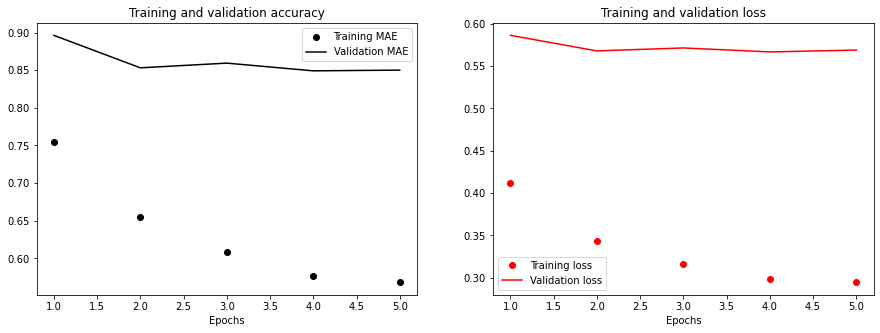

In [26]:
plot_results(history_rnn)

In [27]:
test_loss, test_mae = model_rnn.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}")

175/175 [==============================] - 3s 14ms/step - loss: 0.4378 - mae: 0.7262
Test Loss: 0.4378
 Test MAE: 0.7262


RMSE:  0.5780098
 MAE:  0.48565084


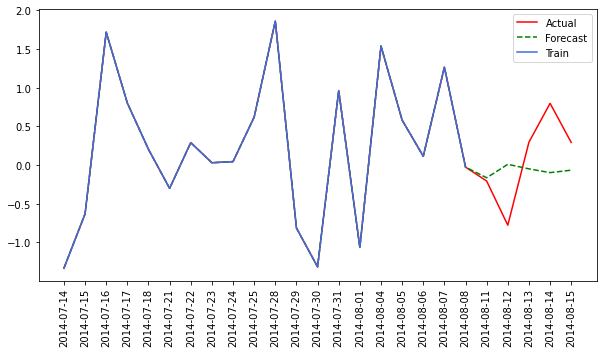

RMSE:  1.0769883
 MAE:  0.78699553


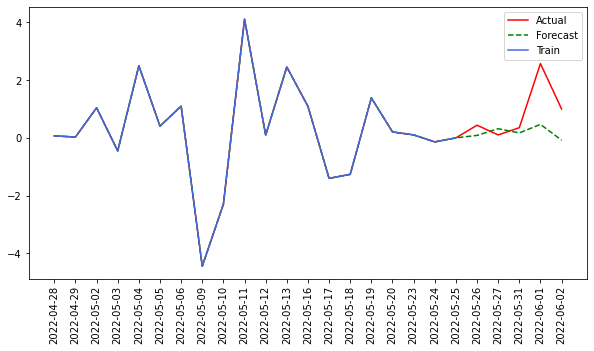

In [28]:
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_rnn.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
        
        if i == 1 or i == 175:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 175:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [29]:
errs_gru = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_rnn.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_gru['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_gru['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change:')
print("Avg. RMSE: ", np.mean(errs_gru['RMSE']))
print(" Avg. MAE: ", np.mean(errs_gru['MAE']))

In percent change:
Avg. RMSE:  1.7719147
 Avg. MAE:  1.3394685


## Extract TSFresh Features

In [54]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame

In [64]:
ts_df

,Return,crb_index,us_dollar_index,google_searches,Date,ticker
Date,,,,,,
2014-07-14,0.378108,297.4700,80.230,13.0,2014-07-14,Dubai
2014-07-15,-0.282512,296.0200,80.446,16.0,2014-07-15,Dubai
2014-07-16,0.047219,296.7900,80.625,15.0,2014-07-16,Dubai
2014-07-17,0.396451,297.9200,80.570,15.0,2014-07-17,Dubai
2014-07-18,-0.366679,297.4200,80.595,11.0,2014-07-18,Dubai
...,...,...,...,...,...,...
2022-05-26,0.438556,318.6633,101.858,16.0,2022-05-26,Dubai
2022-05-27,0.102192,320.5242,101.698,17.0,2022-05-27,Dubai
2022-05-31,0.352668,316.5352,101.766,22.0,2022-05-31,Dubai


In [88]:
ts_data = ts_df.reset_index('Date')
ts_data["ticker"] = "Dubai"
y = ts_df['Return'][5:]

df_rolled = roll_time_series(ts_data, column_id="ticker", column_sort="Date",
                             max_timeshift=20, min_timeshift=5)

X_return = extract_features(df_rolled.drop("ticker", axis=1),
                            column_id="id", column_sort="Date", 
                            impute_function=impute,
                            column_value="Return", show_warnings=False)

/home/msds2022/jegonzales/.local/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Feature Extraction: 100%|██████████| 80/80 [01:23<00:00,  1.04s/it]


In [89]:
X_return = X_return.set_index(X_return.index.map(lambda x: x[1]), drop=True)
X_return.index.name = "Date"
X_return

,Return__variance_larger_than_standard_deviation,Return__has_duplicate_max,Return__has_duplicate_min,Return__has_duplicate,Return__sum_values,Return__abs_energy,Return__mean_abs_change,Return__mean_change,Return__mean_second_derivative_central,Return__median,...,Return__permutation_entropy__dimension_6__tau_1,Return__permutation_entropy__dimension_7__tau_1,Return__query_similarity_count__query_None__threshold_0.0,"Return__matrix_profile__feature_""min""__threshold_0.98","Return__matrix_profile__feature_""max""__threshold_0.98","Return__matrix_profile__feature_""mean""__threshold_0.98","Return__matrix_profile__feature_""median""__threshold_0.98","Return__matrix_profile__feature_""25""__threshold_0.98","Return__matrix_profile__feature_""75""__threshold_0.98",Return__mean_n_absolute_max__number_of_maxima_7
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-21,0.0,0.0,0.0,0.0,0.408501,0.572291,0.541062,-0.028438,0.157902,0.141567,...,-0.000000,2.708050,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,2.059822
2014-07-22,0.0,0.0,0.0,0.0,0.427330,0.572646,0.487066,-0.059880,0.044353,0.047219,...,0.693147,-0.000000,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,2.059822
2014-07-23,0.0,0.0,0.0,0.0,0.540282,0.585404,0.430931,-0.037879,0.062895,0.080085,...,1.098612,0.693147,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,0.259977
2014-07-24,0.0,0.0,0.0,0.0,0.352241,0.620763,0.414689,-0.070769,0.025688,0.047219,...,1.386294,1.098612,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,0.280094
2014-07-25,0.0,0.0,0.0,0.0,0.587735,0.676221,0.415672,-0.015846,0.067760,0.080085,...,1.609438,1.386294,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,0.297600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,1.0,0.0,0.0,0.0,5.026864,63.792852,1.874825,0.018519,0.012567,0.102602,...,2.772589,2.708050,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,2.655509
2022-05-27,1.0,0.0,0.0,0.0,5.060890,63.798649,1.889695,0.003650,-0.035477,0.102602,...,2.772589,2.708050,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,2.655509
2022-05-31,1.0,0.0,0.0,0.0,5.384364,63.922171,1.851631,-0.034414,0.045894,0.205627,...,2.685945,2.708050,0.0,1.26275,3.47713,2.609362,2.893612,1.616826,3.121244,2.655509


In [105]:
X_return_filtered = select_features(X_return, y)

ts_tsfresh = X_return_filtered
ts_tsfresh['Return'] = y
ts_tsfresh = ts_tsfresh.sort_index(axis=1)

In [106]:
# 70-20-10 split
train_size = int(0.7 * len(ts_tsfresh))
val_size = int(0.2 * len(ts_tsfresh))
test_size = len(ts_tsfresh) - train_size - val_size

print(f'Train size: {train_size}')
print(f'  Val size: {val_size}')
print(f' Test size: {test_size}')

Train size: 1386
  Val size: 396
 Test size: 198


In [107]:
# Normalize per dataframe column
train_mean = ts_tsfresh[:train_size].mean()
train_std = ts_tsfresh[:train_size].std()

ts_tsfresh_norm = (ts_tsfresh - train_mean) / train_std

ts_tsfresh_norm

,Return,"Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","Return__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","Return__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""",...,Return__quantile__q_0.6,Return__quantile__q_0.7,Return__quantile__q_0.8,Return__quantile__q_0.9,Return__range_count__max_0__min_-1000000000000.0,Return__range_count__max_1000000000000.0__min_0,Return__skewness,Return__sum_values,Return__symmetry_looking__r_0.1,Return__variance_larger_than_standard_deviation
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-21,0.137879,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,0.390723,-0.169719,-0.622586,-0.920625,-2.848725,-2.491241,-0.185965,0.076652,0.09342,-1.703564
2014-07-22,0.020303,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,0.019423,-0.316065,-0.679343,-0.922420,-2.848725,-2.131230,-0.139361,0.078517,0.09342,-1.703564
2014-07-23,0.071281,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,-0.093191,-0.455815,-0.736101,-0.924216,-2.848725,-1.771220,-0.191423,0.089709,0.09342,-1.703564
2014-07-24,-0.091738,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,-0.278841,-0.582373,-0.792858,-0.926011,-2.492345,-1.771220,-0.022008,0.071078,0.09342,-1.703564
2014-07-25,0.137650,-0.227139,0.146038,0.274429,-0.866312,0.067239,0.977018,-0.427747,-0.089684,0.423879,...,0.026957,-0.414644,-0.849616,-0.927807,-2.492345,-1.411210,-0.133476,0.094410,0.09342,-1.703564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,0.247630,0.509519,0.299351,-0.534003,0.929903,0.338013,-0.239578,-0.878613,1.254533,0.858238,...,1.226306,2.348255,0.817421,1.103824,-1.423205,1.468874,-0.171374,0.534240,0.09342,0.586581
2022-05-27,0.065454,0.531763,0.404142,-0.509438,0.968274,0.512381,-0.199663,-0.871670,-0.720411,0.840530,...,1.226306,2.348255,0.817421,1.103824,-1.423205,1.468874,-0.173005,0.537611,0.09342,0.586581
2022-05-31,0.201113,0.373400,0.527293,-0.527731,0.817401,0.637928,-0.229386,-0.815677,-0.283027,0.854426,...,1.226306,2.348255,0.817421,1.103824,-1.423205,1.468874,-0.188234,0.569661,0.09342,0.586581


In [108]:
target = ['Return']
covariates = list(ts_tsfresh_norm.columns.drop('Return'))

ts = ts_tsfresh_norm[target + covariates].to_numpy() # we assume first column is the target
ts_train = ts[:train_size]
ts_val = ts[train_size:train_size+val_size]
ts_test = ts[train_size+val_size:]

In [110]:
# Hyperparms
w = 20 # one month lookback 
h = 5 # predict next 24 hours 

# Other params
batch_size = 1
seed = 42
shuffle = False

# Create train iterators
x_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create val iterators
x_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create test iterators
x_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# zip datasets
train_ds = tf.data.Dataset.zip((x_train, y_train))
val_ds = tf.data.Dataset.zip((x_val, y_val))
test_ds = tf.data.Dataset.zip((x_test, y_test))

# check sizes
for inputs, targets in train_ds:
    print(inputs.shape)
    print(targets.shape)
    break

(1, 20, 136)
(1, 5)


In [111]:
for inputs, targets in test_ds:
    print(inputs)
    print(targets)
    print('---')

tf.Tensor(
[[[-0.3322294  -0.47313351 -0.41914591 ... -0.68830265  0.09342014
   -1.7035639 ]
  [ 0.93948859 -0.6284159  -1.10011172 ... -0.5264482   0.09342014
    0.58658117]
  [ 0.44332738 -0.56783242 -0.91264099 ... -0.44175684  0.09342014
    0.58658117]
  ...
  [ 0.69481605 -0.41633445 -0.17435337 ...  0.40378061  0.09342014
   -1.7035639 ]
  [-0.00492016 -0.33089357  0.25153276 ...  0.4295318   0.09342014
   -1.7035639 ]
  [-0.10261931 -0.31896407  0.41034725 ...  0.46321632  0.09342014
   -1.7035639 ]]], shape=(1, 20, 136), dtype=float64)
tf.Tensor([[-0.41161196  0.16949081  0.44145311  0.16776749  0.08496481]], shape=(1, 5), dtype=float64)
---
tf.Tensor(
[[[ 0.93948859 -0.6284159  -1.10011172 ... -0.5264482   0.09342014
    0.58658117]
  [ 0.44332738 -0.56783242 -0.91264099 ... -0.44175684  0.09342014
    0.58658117]
  [ 0.11950521 -0.34344478 -0.58576984 ... -0.41902266  0.09342014
    0.58658117]
  ...
  [-0.00492016 -0.33089357  0.25153276 ...  0.4295318   0.09342014
   -1.

In [112]:
print('Number of train splits: ', len(train_ds))
print('Number of val splits: ', len(val_ds))
print('Number of test splits: ', len(test_ds))

Number of train splits:  1362
Number of val splits:  372
Number of test splits:  174


## Multilayer Perceptron - tsFresh

In [113]:
# MLP

model_mlp_tsfresh = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 136)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(h, activation="linear")
])

model_mlp_tsfresh.compile(
    optimizer='adam',
    loss='huber',
    metrics=['mae']
)

In [114]:
history_mlp_tsfresh = model_mlp_tsfresh.fit(train_ds, epochs=5, 
                                            validation_data=val_ds)

Epoch 1/5
1362/1362 [==============================] - 10s 6ms/step - loss: 2.8057 - mae: 3.2375 - val_loss: 6.2535 - val_mae: 6.6533
Epoch 2/5
1362/1362 [==============================] - 9s 6ms/step - loss: 1.4578 - mae: 1.8666 - val_loss: 2.3866 - val_mae: 2.7343
Epoch 3/5
1362/1362 [==============================] - 9s 6ms/step - loss: 0.4350 - mae: 0.7617 - val_loss: 0.7229 - val_mae: 1.0391
Epoch 4/5
1362/1362 [==============================] - 8s 6ms/step - loss: 0.3120 - mae: 0.5938 - val_loss: 0.6143 - val_mae: 0.9109
Epoch 5/5
1362/1362 [==============================] - 9s 6ms/step - loss: 0.3072 - mae: 0.5846 - val_loss: 0.8782 - val_mae: 1.2165


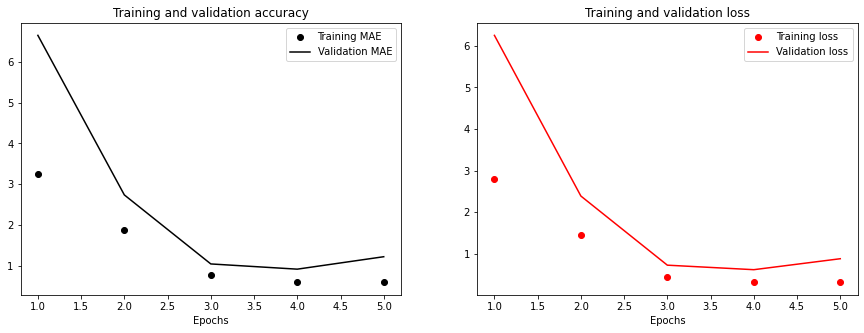

In [115]:
plot_results(history_mlp_tsfresh)

In [117]:
# unscaled MAE

test_loss, test_mae = model_mlp_tsfresh.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

174/174 [==============================] - 1s 4ms/step - loss: 0.4852 - mae: 0.7974
Test Loss: 0.4852
 Test MAE: 0.7974


RMSE:  0.47431406
 MAE:  0.40206093


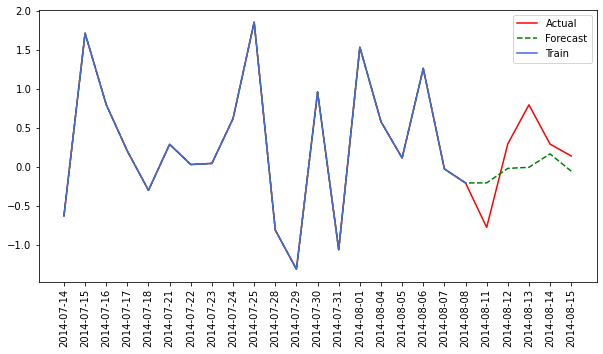

RMSE:  1.2320477
 MAE:  0.8640424


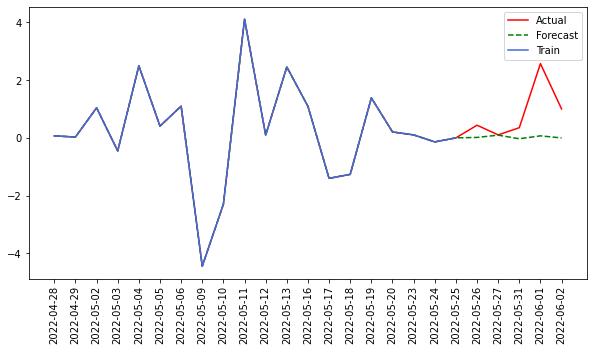

In [119]:
# Sample plots
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_mlp_tsfresh.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
    
        if i == 1 or i == 174:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 174:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [121]:
errs_mlp_tsfresh = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_mlp_tsfresh.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_mlp_tsfresh['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_mlp_tsfresh['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change: ')
print("Avg. RMSE: ", np.mean(errs_mlp_tsfresh['RMSE']))
print(" Avg. MAE: ", np.mean(errs_mlp_tsfresh['MAE']))

In percent change: 
Avg. RMSE:  1.9221151
 Avg. MAE:  1.4722844


## RNN - tsFresh

In [122]:
model_rnn_tsfresh = Sequential()
model_rnn_tsfresh.add(SimpleRNN(150, return_sequences=True,
              input_shape=(None, 136)))
model_rnn_tsfresh.add(SimpleRNN(75, return_sequences=False,
              input_shape=(None, 136)))
model_rnn_tsfresh.add(Dropout(0.2))
model_rnn_tsfresh.add(Dense(h))

model_rnn_tsfresh.compile(loss='huber',
                  optimizer='adam', 
                  metrics=['mae'])

In [124]:
history_rnn_tsfresh = model_rnn_tsfresh.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

Epoch 1/5
1362/1362 [==============================] - 67s 47ms/step - loss: 0.4284 - mae: 0.7739 - val_loss: 0.5961 - val_mae: 0.9034
Epoch 2/5
1362/1362 [==============================] - 63s 47ms/step - loss: 0.3524 - mae: 0.6673 - val_loss: 0.6088 - val_mae: 0.9287
Epoch 3/5
1362/1362 [==============================] - 65s 48ms/step - loss: 0.3194 - mae: 0.6157 - val_loss: 0.5652 - val_mae: 0.8479
Epoch 4/5
1362/1362 [==============================] - 64s 47ms/step - loss: 0.2985 - mae: 0.5779 - val_loss: 0.5639 - val_mae: 0.8383
Epoch 5/5
1362/1362 [==============================] - 64s 47ms/step - loss: 0.2936 - mae: 0.5675 - val_loss: 0.5636 - val_mae: 0.8402


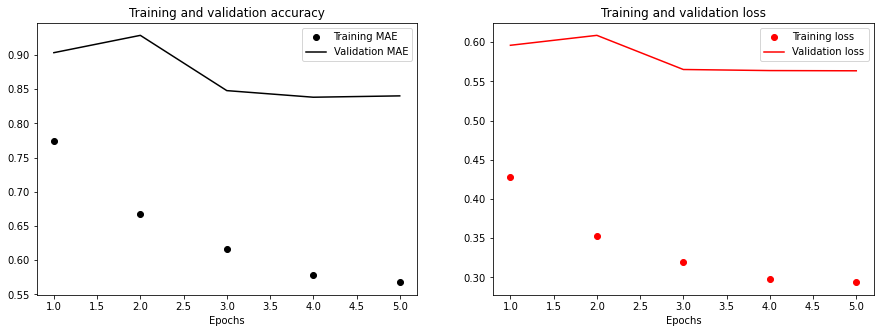

In [125]:
plot_results(history_rnn_tsfresh)

In [126]:
# unscaled MAE

test_loss, test_mae = model_rnn_tsfresh.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f" Test MAE: {test_mae:.4f}") 

174/174 [==============================] - 2s 13ms/step - loss: 0.4384 - mae: 0.7242
Test Loss: 0.4384
 Test MAE: 0.7242


RMSE:  0.4803027
 MAE:  0.3549605


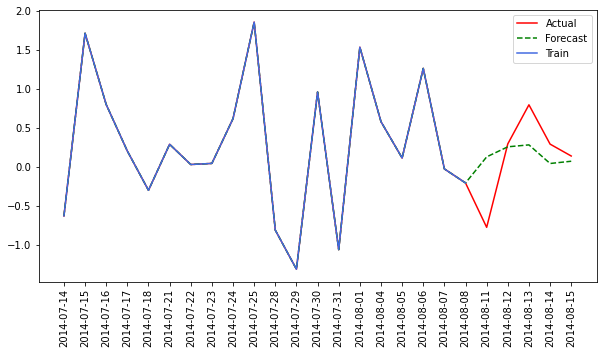

RMSE:  1.1803402
 MAE:  0.78679776


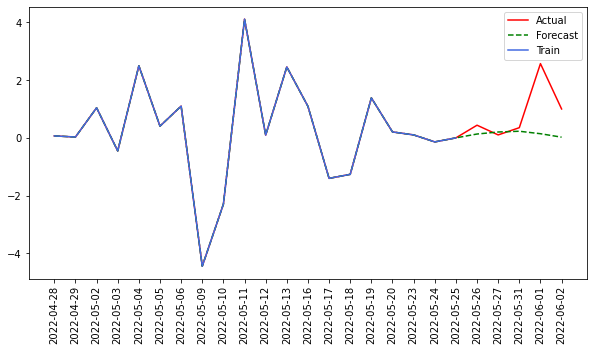

In [127]:
# Sample plots
i = 1
for x_test, y_test in test_ds.take(-1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model_rnn_tsfresh.predict(x_test[np.newaxis, idx], verbose=0).squeeze(0)

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
    
        if i == 1 or i == 174:
            print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
            print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
            plt.figure(figsize=(10, 5))            
            plt.plot(np.append(sample_x, sample_y), color='red', label='Actual')
            plt.plot(np.append(sample_x, sample_forecast), color='green', linestyle='--', label='Forecast')
            plt.plot(sample_x, label='Train', color='royalblue')
            plt.legend()
            
            if i == 174:
                plt.xticks(list(range(25)), ts_df.index[-25:].astype(str), rotation=90)
            else:
                plt.xticks(list(range(25)), ts_df.index[:25].astype(str), rotation=90)
            plt.show()
        i += 1

In [128]:
errs_rnn_tsfresh = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model_rnn_tsfresh.predict(x_test, verbose=0).squeeze(0)
    
    y_test = y_test[0, :].numpy() * train_std[target][0] + train_mean[target][0]
    forecast = forecast * train_std[target][0] + train_mean[target][0]
    
    errs_rnn_tsfresh['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_rnn_tsfresh['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In percent change:')
print("Avg. RMSE: ", np.mean(errs_rnn_tsfresh['RMSE']))
print(" Avg. MAE: ", np.mean(errs_rnn_tsfresh['MAE']))

In percent change:
Avg. RMSE:  1.7714345
 Avg. MAE:  1.3371676


## Summary of Results

| Model | Features | MAE | RMSE | Run Times |
| --- | --- | --- | --- | --- |
| Multilayer Perceptron | Macroeconomic Indicators & Google Trends | 1.4728135 | 1.8928516 | 44 s
| Multilayer Perceptron | TSFresh Extracted Features from Return Series | 1.4722844 | 1.8922115 | 45 s
| RNN | Macroeconomic Indicators & Google Trends | 1.3394685 | 1.7719147 | 5 m 11 s
| RNN | TSFresh Extracted Features from Return Series | 1.3371676  | 1.7714345 | 5 m 23 s